<a href="https://colab.research.google.com/github/vifirsanova/100-days-of-code/blob/main/day17/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Автор: [Виктория Фирсанова](https://github.com/vifirsanova)

# Загрузка пакетов, библиотек и дополнительных файлов

In [ ]:
# цветной вывод
pip install colorama

In [ ]:
import json
import random
from colorama import Fore, Style
import re
from collections import defaultdict
import numpy as np
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import copy
from sklearn.decomposition import TruncatedSVD
import gensim

In [ ]:
# список стоп-слов
!wget https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.txt

--2021-05-09 09:59:08--  https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6229 (6.1K) [text/plain]
Saving to: ‘stopwords-ru.txt’

stopwords-ru.txt    100%[===================>]   6.08K  --.-KB/s    in 0s      

2021-05-09 09:59:08 (68.3 MB/s) - ‘stopwords-ru.txt’ saved [6229/6229]



# Загрузка корпуса

Для обучения используем собственный [корпус новостей газеты Московский комсомолец за 2020-2021 года.](https://drive.google.com/file/d/1ebxe77hTEWvmUggCMnRGdrVDwhuxC9Mr/view)

In [ ]:
# Загрузка данных и подготовка корпуса
with open('corpus.json', encoding='utf-8', newline='') as json_file:
    data = json.load(json_file)

full_dataset = []

for elem in data['data']:
    full_dataset.append(elem['text'])

# случайное перемешивание данных
random.shuffle(full_dataset)

# деление на обучающую и проверочную выборку
TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.8)
train = full_dataset[:TRAIN_VAL_SPLIT]
val = full_dataset[TRAIN_VAL_SPLIT:]

print(f"{Fore.RED}Размер обучающей выборки:{Style.RESET_ALL} {len(train)} новостей\
\n{Fore.RED}Размер проверочной выборки:{Style.RESET_ALL} {len(val)} новостей\n\
\n{Fore.RED}Образец текста из выборки:{Style.RESET_ALL}\n", ''.join(train[0]))

Размер обучающей выборки: 36736 новостей
Размер проверочной выборки: 9184 новостей

Образец текста из выборки:
 
В люксовых гостиинцах Москвы средний тариф вырос на 23%, утверждают в компании CBRE. При этом в организации подчеркивают, что во второй половине мая в городе оживилась деловая активность. Благодаря этому, в мае наполняемость отелей составила 14% против 8% в предыдущем месяце. При этом очевидно, что, чем дороже гостиница, тем меньше там людей. Ожидается, что в июне постояльцев станет еще больше, благодаря отмене ограничений по коронавирусу.




# Токенизация

In [ ]:
# построим токенизатор, который приводит тексты к нижнему регистру и удаляет все символы, кроме букв и цифр
def tokenizer(text):
    """
    Токенизатор
    :text: текст для токенизации (str)
    :return: токенизированный текст (list)
    """
    tokens = re.compile(r'[\w\d]+').findall(text.lower())
    return [token for token in tokens if len(token)]


# функция для токенизации корпуса
def tokenize(corpus, tokenizer=tokenizer):
    """
    Токенизация
    :corpus: корпус текстов или датасет (list)
    :tokenizer: типа токенизатора (func)
    :return: токенизированный корпус/датасет (list)
    """
    return [tokenizer(text) for text in corpus]


# токенизируем
train_tokenized = tokenize(train)
val_tokenized = tokenize(val)
print(f"{Fore.RED}Образец токенизированного текста:{Style.RESET_ALL}\n", ' '.join(train_tokenized[0]))

Образец токенизированного текста:
 в люксовых гостиинцах москвы средний тариф вырос на 23 утверждают в компании cbre при этом в организации подчеркивают что во второй половине мая в городе оживилась деловая активность благодаря этому в мае наполняемость отелей составила 14 против 8 в предыдущем месяце при этом очевидно что чем дороже гостиница тем меньше там людей ожидается что в июне постояльцев станет еще больше благодаря отмене ограничений по коронавирусу


# Построение словаря

In [ ]:
# стоп-слова 
stop_words = []

with open('stopwords-ru.txt', encoding='utf-8') as f:
    for word in f:
      stop_words.append(word[:-1])


def build_vocab(data_tokenized, pad_word=None, stop_words=stop_words):
    freq_dict = defaultdict(int) # количество словоупотреблений в документах 
    doc_n = len(data_tokenized) # общее количество документов

    # посчитать количество словоупотреблений в документах 
    for text in data_tokenized:
        unique_text_tokens = set(text)
        for token in unique_text_tokens:
            freq_dict[token] += 1


    # удалить стоп-слова
    for word in list(freq_dict.keys()):
        if word in stop_words:
            freq_dict.pop(word)


    # удалить уникальные слова
    freq_dict = {word: count for word, count in freq_dict.items() if count > 1}

    # отсортировать слова по убыванию частоты
    sorted_freq_dict = sorted(freq_dict.items(),
                                reverse=True,
                                key=lambda x: x[1])

    # паддинг
    padded_freq_dict = [(pad_word, 0)] + sorted_freq_dict
    
    # обновить нумерацию слов
    word2id = {word: i for i, (word, _) in enumerate(padded_freq_dict)}

    # преобразуем частотный словарь к виду матриц чисел
    word2freq = np.array([count / doc_n for _, count in padded_freq_dict], dtype='float32')

    return word2id, word2freq


# строим словарь для обучающей выборки
vocabulary, word_doc_freq = build_vocab(train_tokenized, pad_word='<PAD>', stop_words=stop_words)

print(f"{Fore.RED}Размер словаря:{Style.RESET_ALL} {len(vocabulary)}\n")
print(f"{Fore.RED}Образец словаря{Style.RESET_ALL}\n", list(vocabulary.items())[:10])

Размер словаря: 85694

Образец словаря
 [('<PAD>', 0), ('россии', 1), ('ранее', 2), ('заявил', 3), ('словам', 4), ('коронавируса', 5), ('сообщает', 6), ('сша', 7), ('отметил', 8), ('сообщил', 9)]


# Векторизация

In [ ]:
def texts2ids(data_tokenized, word2id):
    return [[word2id[token] for token in text if token in word2id]
            for text in data_tokenized]

# конвертация
train_token_ids = texts2ids(train_tokenized, vocabulary)
val_token_ids = texts2ids(val_tokenized, vocabulary)

print(f"{Fore.RED}Образец токенизированного текста{Style.RESET_ALL}\n", 
      ' '.join(train_tokenized[0][:5]))
print(f"{Fore.RED}Образец числовых представлений для этого текста{Style.RESET_ALL}\n", 
      ''.join(str(train_token_ids[0][:3])))
n1, n2, n3 = train_token_ids[0][0], train_token_ids[0][1], train_token_ids[0][2]
print(f"{Fore.RED}Расшифровка с помощью словаря{Style.RESET_ALL}\n", list(vocabulary.items())[n1], 
      list(vocabulary.items())[n2], list(vocabulary.items())[n3])

Образец токенизированного текста
 в люксовых гостиинцах москвы средний
Образец числовых представлений для этого текста
 [37480, 151, 3983]
Расшифровка с помощью словаря
 ('люксовых', 37480) ('москвы', 151) ('средний', 3983)


# Паддинг

In [ ]:
# паддинг последовательностей (текстов):
# мы задаем длину n для последовательностей обучающих данных,
# обрезаем все тексты, которые превышают эту длину
# и заполняем нулями все тексты, длина которых ниже заданной длины

class PaddedSequenceDataset(Dataset):
    def __init__(self, data, targets, out_len=100, pad_value=0):
        self.data = data
        self.targets = targets
        self.out_len = out_len
        self.pad_value = pad_value

    def __len__(self):
        return len(self.data)

    def ensure_length(self, txt, out_len, pad_value):
        if len(txt) < out_len:
            txt = list(txt) + [pad_value] * (out_len - len(txt))
        else:
            txt = txt[:out_len]
        return txt

    def __getitem__(self, item):
        txt = self.data[item]
        txt = self.ensure_length(txt, self.out_len, self.pad_value)
        txt = torch.tensor(txt, dtype=torch.long)
        target = torch.tensor(self.targets[item], dtype=torch.long)

        return txt, target


# максимальная длина последовательности
MAX_SENTENCE_LEN = 50

# применить паддинг
train_dataset = PaddedSequenceDataset(train_token_ids,
                                      np.zeros(len(train_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)
val_dataset = PaddedSequenceDataset(test_token_ids,
                                     np.zeros(len(test_token_ids)),
                                     out_len=MAX_SENTENCE_LEN)

print(f"{Fore.RED}Образец числовых представлений для текста из выборки{Style.RESET_ALL}\n", 
      ''.join(str(train_token_ids[0])))
print(f"{Fore.RED}\nТо же после применения паддинга{Style.RESET_ALL}\n", train_dataset[0])

Образец числовых представлений для текста из выборки
 [37480, 151, 3983, 16183, 1708, 318, 1011, 274, 236, 5729, 3279, 266, 249, 33411, 3934, 790, 1514, 62309, 10087, 917, 246, 170, 22174, 3749, 4208, 7933, 27660, 172, 539, 1837, 10636, 501, 790, 3280, 668, 863]

То же после применения паддинга
 (tensor([37480,   151,  3983, 16183,  1708,   318,  1011,   274,   236,  5729,
         3279,   266,   249, 33411,  3934,   790,  1514, 62309, 10087,   917,
          246,   170, 22174,  3749,  4208,  7933, 27660,   172,   539,  1837,
        10636,   501,   790,  3280,   668,   863,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), tensor(0))


# Модель

In [ ]:
# побочная функция создает квадратную матрицу
# потребуется для создания маски для обучения модели
def make_diag_mask(size, radius):
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask


# модель Skip Gram Negative Sampling
class SkipGramNegativeSampling(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, radius=3, negative_samples_n=30):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.center_emb.weight.data[0] = 0

        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0

        self.positive_sim_mask = make_diag_mask(sentence_len, radius)

    def forward(self, sentences):
        batch_size = sentences.shape[0]
        center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

        # оценить сходство с соседними словами
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        positive_probs = torch.sigmoid(positive_sims)

        # увеличить оценку вероятности совместной встречаемости для пар слов
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                               positive_mask.expand_as(positive_probs))

        # выбрать случайные "отрицательные" слова
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN
        
        # уменьшить оценку вероятности совместной встречаемости для пар слов
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))

        return positive_loss + negative_loss


# фиктивная функция потерь
def no_loss(pred, target):
    return pred

# Обучение

In [ ]:
# функция для сохранения обученной модели
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError()


def train_and_eval(model, train_dataset, val_dataset, loss_func,
                   lr=1e-4, epochs=10, batch_size=32,
                   device=None, early_stopping_patience=10, l2=0,
                   max_batches_per_epoch_train=10000,
                   max_batches_per_epoch_val=1000,
                   data_loader=DataLoader,
                   optimizer=None,
                   lr_scheduler=None,
                   shuffle_train=True,
                   dataloader_workers_n=0):
    """
    Цикл для обучения и оценки модели
    :model: модель для обучения (torch.nn.Module)
    :train_dataset: обучающая выборка (torch.utils.data.Dataset)
    :val_dataset: проверочная выборка (torch.utils.data.Dataset)
    :loss_func: функция потерь (func)
    :lr: скорость обучения (float)
    :epochs: количество эпох обучения (int)
    :batch_size: размер батча (int)
    :device: cuda/cpu (str)
    :early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели (int)
    :l2: коэффициент L2-регуляризации (int)
    :max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения (int)
    :max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации (int)
    :data_loader: преобразует датасет в батчи (torch.utils.data.DataLoader)
    :optimizer: оптимизатор (torch.optim.optimizer)
    :lr_scheduler: задает скорость обучения (torch.optim.lr_scheduler)
    :shuffle_train: перемешать данные в обучающей выборке (Bool)
    :return: среднее значение функции потерь на валидации на лучшей эпохе, лучшая модель (tuple)
    """
    device = torch.device(device)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    lr_scheduler = lr_scheduler(optimizer)
    train_dataloader = data_loader(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)

    best_val_loss = float('inf')
    best_epoch = 0
    best_model = copy.deepcopy(model)

    for epoch in range(epochs):
        try:
            print(f"Эпоха {epoch}")

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                pred = model(batch_x)
                loss = loss_func(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n
            print(f"Mean train loss = {mean_train_loss}")


            # После каждой эпохи качество модели оценивается по проверочной выборке
            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = loss_func(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            print(f"Mean val loss = {mean_val_loss}")

            if mean_val_loss < best_val_loss:
                best_epoch = epoch
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
            elif epoch - best_epoch > early_stopping_patience:
                print("Early stopping")
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)

            print()
            
        except KeyboardInterrupt:
            break
        except Exception as ex:
            print(ex)
            break

    return best_val_loss, best_model

model = SkipGramNegativeSampling(vocab_size=len(vocabulary), emb_size=100, sentence_len=MAX_SENTENCE_LEN, radius=3, negative_samples_n=30)

best_val_loss, best_model = train_and_eval(model,
                                           train_dataset,
                                           val_dataset,
                                           no_loss,
                                           lr=1e-2,
                                           epochs=5,
                                           batch_size=4,
                                           device='cpu',
                                           early_stopping_patience=5,
                                           max_batches_per_epoch_train=2000,
                                           max_batches_per_epoch_val=len(val_dataset),
                                           lr_scheduler=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

Эпоха 0
Mean train loss = 0.6777163267373919
Mean val loss = 0.5409589928643006

Эпоха 1
Mean train loss = 0.4658630435643108
Mean val loss = 0.4107668593084563

Эпоха 2
Mean train loss = 0.39998311651074725
Mean val loss = 0.38837730107692686

Эпоха 3
Mean train loss = 0.37731792836979233
Mean val loss = 0.3714471168699269

Эпоха 4
Mean train loss = 0.35946254441137615
Mean val loss = 0.36270631546680315



# Анализ

In [ ]:
class Word2Vec:
    def __init__(self, embeddings, word2id):
        self.embeddings = embeddings
        self.embeddings /= (np.linalg.norm(self.embeddings, ord=2, axis=-1, keepdims=True) + 1e-4)
        self.word2id = word2id
        self.id2word = {i: w for w, i in word2id.items()}


    def similar(self, word, num=10):
        """
        Функция находит наиболее похожие слова на данное (в основе - функция get_similar)
        :word: слово для анализа (str)
        :num: количество сходных слов для отображения (int)
        :return: num кортежей вида ('аналогичное слово' (str), вероятность сходства (0 <= float <= 1)) (list)
        """
        return self.get_similar(self.get_vector(word), num=num)


    def get_similar(self, vec, num=10):
        """
        Функция находит наиболее похожие вектора на данный
        :vec: вектор слова для анализа (numpy.ndarray)
        :num: количество сходных слов для отображения (int)
        :return: num кортежей вида ('аналогичное слово' (str), вероятность сходства (0 <= float <= 1)) (list)
        """
        similarities = (self.embeddings * vec).sum(-1) # сходные слова
        top_similar = np.argpartition(-similarities, num, axis=0)[:num]
        result = [(self.id2word[i], similarities[i]) for i in top_similar] # список кортежей
        result.sort(key=lambda x: -x[1]) # сортировка результата по убыванию
        return result


    def get_vector(self, word):
        if word not in self.word2id:
            raise ValueError('Неизвестное слово "{}"'.format(word))
        return self.embeddings[self.word2id[word]]


    def get_vectors(self, *words):
        word_ids = [self.word2id[i] for i in words]
        vectors = np.stack([self.embeddings[i] for i in word_ids], axis=0)
        return vectors


embeddings = Word2Vec(model.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [ ]:
embeddings.similar('президент')

[('президент', 0.9998),
 ('владимир', 0.7096379),
 ('заявил', 0.6802817),
 ('путин', 0.6715473),
 ('министр', 0.66285056),
 ('лидер', 0.62618214),
 ('президента', 0.6182108),
 ('эммануэль', 0.6089274),
 ('макрон', 0.604155),
 ('премьер', 0.59916675)]

In [ ]:
embeddings.similar('коронавирус')

[('коронавирус', 0.99979997),
 ('covid', 0.6591861),
 ('19', 0.6286661),
 ('тест', 0.6116188),
 ('положительным', 0.6109684),
 ('диагнозом', 0.57951033),
 ('заболевания', 0.5698585),
 ('пневмония', 0.5659813),
 ('пациентов', 0.55714273),
 ('типа', 0.5552652)]

In [ ]:
embeddings.similar('рф')

[('рф', 0.99980015),
 ('россии', 0.7222661),
 ('ранее', 0.64365655),
 ('отмечается', 0.60396975),
 ('мвд', 0.60178494),
 ('первом', 0.60088485),
 ('турции', 0.6003749),
 ('словам', 0.59671444),
 ('управления', 0.5889615),
 ('глава', 0.587755)]

Визуализация тематических кластеров векторов слов


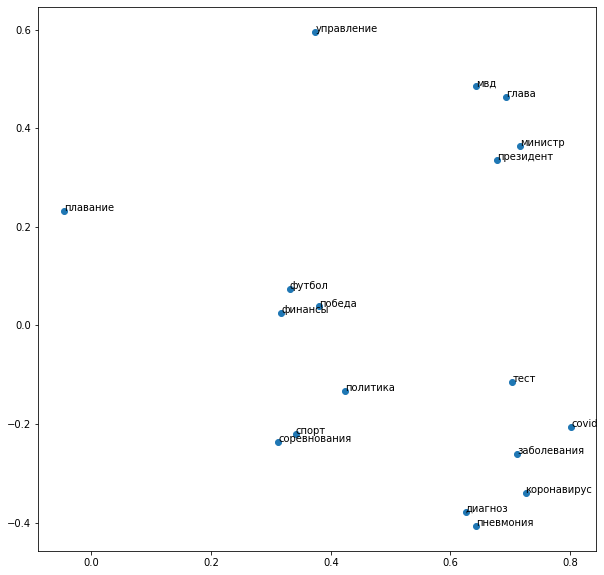

In [ ]:
clustering_words = ['коронавирус', 'covid', 'тест', 'диагноз', 'пневмония', 'заболевания', 'футбол', 'спорт', 'плавание', 'соревнования', 'победа', 'политика', 'президент', 'министр', 'финансы', 'управление', 'глава', 'мвд']
clustering_vectors = embeddings.get_vectors(*clustering_words)
print("Визуализация тематических кластеров векторов слов")

fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
projections = TruncatedSVD().fit_transform(clustering_vectors)
x = projections[:, 0]
y = projections[:, 1]
ax.scatter(x, y)
for cur_x, cur_y, cur_label in zip(x, y, clustering_words):
    ax.annotate(cur_label, (cur_x, cur_y))

# Обучение Word2Vec с помощью Gensim

In [ ]:
word2vec = gensim.models.Word2Vec(sentences=train_tokenized, size=100,
                                  window=5, min_count=5, workers=4,
                                  sg=1, iter=10)

In [ ]:
word2vec.wv.most_similar('президент')

[('токаев', 0.6945623755455017),
 ('жомарт', 0.6942183971405029),
 ('путин', 0.680253803730011),
 ('касым', 0.6665109395980835),
 ('обрадор', 0.6630406975746155),
 ('октай', 0.6577010154724121),
 ('избранный', 0.656670868396759),
 ('лидер', 0.6481192111968994),
 ('вольфович', 0.646379828453064),
 ('владимир', 0.642382025718689)]

In [ ]:
word2vec.wv.most_similar('рф')

[('россии', 0.835371732711792),
 ('федерации', 0.5942858457565308),
 ('поручениям', 0.5811846256256104),
 ('российской', 0.5786277055740356),
 ('сфо', 0.5641083717346191),
 ('зеленском', 0.5492971539497375),
 ('бычковский', 0.5424310564994812),
 ('иеговы', 0.5405256748199463),
 ('болгарии', 0.5385011434555054),
 ('страны', 0.5293979644775391)]

In [ ]:
word2vec.wv.most_similar('коронавирус')

[('инфекцию', 0.7976594567298889),
 ('положительным', 0.7539291381835938),
 ('коронавирусную', 0.7456187605857849),
 ('вирус', 0.7368725538253784),
 ('положительный', 0.7361634373664856),
 ('тестом', 0.7306879758834839),
 ('теста', 0.726087212562561),
 ('тест', 0.7246643304824829),
 ('пневмонию', 0.7222490310668945),
 ('болезнь', 0.7155675888061523)]

Визуализация тематических кластеров векторов слов, полученных с помощью Gensim


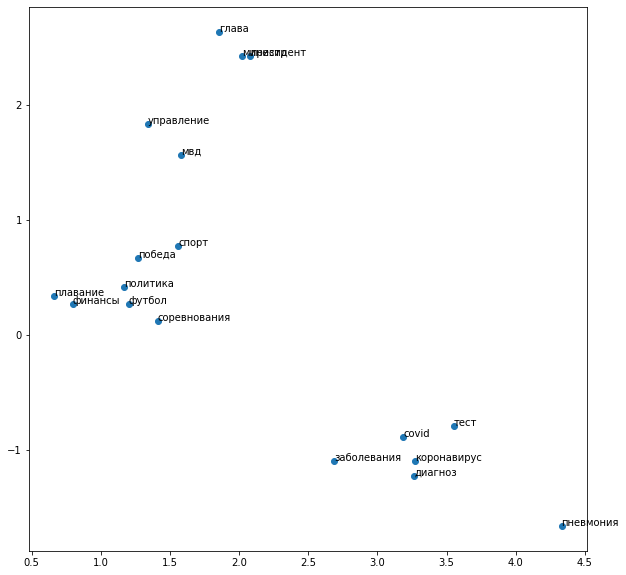

In [ ]:
gensim_vectors = np.stack([word2vec.wv[w] for w in clustering_words])
print("Визуализация тематических кластеров векторов слов, полученных с помощью Gensim")

fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
projections = TruncatedSVD().fit_transform(gensim_vectors)
x = projections[:, 0]
y = projections[:, 1]
ax.scatter(x, y)
for cur_x, cur_y, cur_label in zip(x, y, clustering_words):
    ax.annotate(cur_label, (cur_x, cur_y))